In [1]:
from sklearn.datasets import make_circles, make_moons, make_swiss_roll, make_s_curve
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from cvxopt import matrix
from cvxopt import solvers
from numpy import linalg as LA

## Two moon dataset with only 2 labelled examples

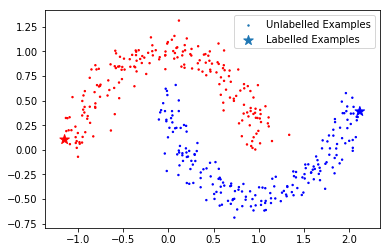

In [2]:
seed = 1
X_original, y_original = make_moons(n_samples=400, noise=0.1, random_state=seed)
y_original[y_original == 0] = -1
d = X_original.shape[-1]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
max_idx = list(X_original[:, 0]).index(max(X_original[:, 0]))
min_idx = list(X_original[:, 0]).index(min(X_original[:, 0]))

#idx = list(range(X_original.shape[0]))
#idx = list(np.random.randint(low=0, high=X_original.shape[0]-1, size=int(X_original.shape[0]*0.1)))
idx = [max_idx, min_idx]
X_lab = X_original[idx]
y_lab = y_original[idx]

mask = np.ones(X_original[:, 0].shape, bool)
mask[idx] = False
X_unlab = X_original[mask]
y_unlab = y_original[mask]

X = np.concatenate((X_lab, np.repeat(X_original, d, axis=0)))
y = np.concatenate((y_lab, np.repeat(y_original, d, axis=0)))

colors = ['red','blue']
plt.scatter(X_unlab[:, 0], X_unlab[:, 1], c=y_unlab, cmap=matplotlib.colors.ListedColormap(colors), s=2)
plt.scatter(X_lab[:, 0], X_lab[:, 1], c=y_lab, cmap=matplotlib.colors.ListedColormap(colors), marker='*', s=100)
plt.legend(['Unlabelled Examples', 'Labelled Examples'])

## Kernel functions and bounded linear functionals on RKHS

In [3]:
y_lab

array([ 1, -1])

In [4]:
sigma_default = 0.1

def gaussian(x1, x2, sigma=sigma_default):
    return np.exp(-1/(2*sigma**2) * LA.norm(x1 - x2, axis=-1)**2)

def z_xij_gaussian(xi, x, j, sigma=sigma_default):
    return 1/(sigma**2) * (x[j] - xi[j]) * gaussian(xi, x, sigma=sigma)

def z_xij_xpq_gaussian(xi, xp, j, q, sigma=sigma_default):
    if j != q:
        return -1/sigma**4 * (xi[j] - xp[j]) * (xi[q] - xp[q]) * gaussian(xi, xp, sigma=sigma)
    else:
        return 1/sigma**4 * (sigma**2 - (xi[j] - xp[j])**2) * gaussian(xi, xp, sigma=sigma)

In [5]:
X.shape

(802, 2)

## Construct K matrix

In [6]:
l = X_lab.shape[0]
dim = X.shape[0]
K = np.zeros((dim, dim))
for i in range(dim):
    for j in range(dim):
        if i < l and j < l:
            K[i, j] = gaussian(X[i], X[j])
        elif i >= l and j < l:
            idx = i % d
            K[i, j] = z_xij_gaussian(X[j], X[i], idx)
        elif i < l and j >= l:
            idx = j % d
            K[i, j] = z_xij_gaussian(X[i], X[j], idx)
        else:
            idx1 = i % d
            idx2 = j % d
            K[i, j] = z_xij_xpq_gaussian(X[i], X[j], idx1, idx2)

## Solve the Quadratic Program

In [7]:
l = X_lab.shape[0]
Dim = l + (dim-l)*d
length = dim - l
Q = np.zeros((Dim, Dim))
Q[l:l+length, l:l+length] = K[l:, l:]
Q[l:l+length, l+length:] = -K[l:, l:]
Q[l+length:, l:l+length] = -K[l:, l:]
Q[l+length:, l+length:] = K[l:, l:]

M = np.zeros((Dim, Dim))
M[:l, :l] = np.outer(y_lab, y_lab) * K[:l, :l]
G = M + Q

G[l:l+length, :l] = -K[l:, :l]
G[l+length:, :l] = K[l:, :l]
G[:l, l:l+length] = K[:l, l:]
G[:l, l+length:] = -K[:l, l:]

Y = np.ones((Dim, Dim))
Y[l:, :l] = np.tile(y_lab, [Dim-l, 1])
Y[:l, l:] = np.tile(y_lab, [Dim-l, 1]).T
P = G * Y

epsilon = 0.001
rho1 = 1
rho2 = 1
q = np.zeros((Dim, 1))
q[:l] = -1
q[l:] = epsilon

N = np.vstack((np.eye(Dim)*(-1.),np.eye(Dim)))
constraint = np.zeros((Dim))
constraint[:l] = 1 / (2*rho1)
constraint[l:] = rho2 / (2*rho1)
h = np.hstack((np.zeros(Dim), constraint))

P = matrix(P)
q = matrix(q)
G = matrix(N)
h = matrix(h)

# run solver
sol = solvers.qp(P, q, G, h)
vals = np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -1.0439e+00 -1.1871e+03  7e+03  3e+00  2e-12
 1: -4.0107e-01 -8.2371e+02  8e+02  5e-16  2e-12
 2: -5.5268e-01 -4.7165e+01  5e+01  1e-16  2e-12
 3: -6.0019e-01 -2.6436e+00  2e+00  1e-16  2e-12
 4: -7.3224e-01 -1.0512e+00  3e-01  1e-16  1e-12
 5: -9.7562e-01 -1.0138e+00  4e-02  2e-16  1e-12
 6: -9.8876e-01 -9.9752e-01  9e-03  2e-16  2e-13
 7: -9.9100e-01 -9.9364e-01  3e-03  2e-16  6e-14
 8: -9.9161e-01 -9.9243e-01  8e-04  2e-16  3e-14
 9: -9.9180e-01 -9.9205e-01  2e-04  2e-16  2e-14
10: -9.9186e-01 -9.9193e-01  8e-05  2e-16  2e-14
11: -9.9187e-01 -9.9189e-01  2e-05  2e-16  2e-14
12: -9.9188e-01 -9.9188e-01  3e-06  2e-16  2e-14
13: -9.9188e-01 -9.9188e-01  4e-07  2e-16  2e-14
Optimal solution found.


In [8]:
beta = vals[0:l]
alpha_prime = vals[l:l+length]
alpha = vals[l+length:]
a = alpha_prime - alpha

In [9]:
sup_vec_idx = np.union1d(np.argwhere(np.logical_or(alpha_prime > 1e-4, alpha_prime < -1e-4)), np.argwhere(np.logical_or(alpha > 1e-4, alpha < -1e-4)))

In [10]:
def classify(x, beta, a, sup_vec_idx):
    val = 0
    for xi, b, y in zip(X_lab, beta, y_lab):
        val += b * gaussian(xi, x) * y
    X_tmp = np.repeat(X_original, d, axis=0)
    for idx in sup_vec_idx:
        j = idx % d
        val += a[idx] * z_xij_gaussian(X_tmp[idx], x, j)
    return np.sign(val)

## Plot the decision boundry

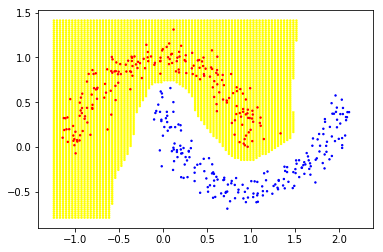

In [11]:
max_x = max(X[:, 0])
min_x = min(X[:, 0])
max_y = max(X[:, -1])
min_y = min(X[:, -1])

xline = np.linspace(min_x-0.1, max_x+0.1, 100)
yline = np.linspace(min_y-0.1, max_y+0.1, 100)

cartesian = []
for x in xline:
    for y in yline:
        cartesian.append((x, y))
cartesian = np.array(cartesian)

predictions = []
for pair in cartesian:
    predictions.append(classify(pair, beta, a, sup_vec_idx))
    
predictions = np.array(predictions)

colors = ['yellow','white']
colors1 = ['red','blue']
plt.scatter(cartesian[:, 0], cartesian[:, 1], c=predictions.squeeze(), cmap=matplotlib.colors.ListedColormap(colors), s=2)
plt.scatter(X_original[:, 0], X_original[:, 1], c=y_original, cmap=matplotlib.colors.ListedColormap(colors1), s=2)